In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn

In [77]:
#Define classes from nn.Module (easy to work with when taking gradients).Note that in the simplest case of Woodford
# encoder and decoder are not strictly necessary, as they are both determined by the same parameters.
class CategoricalEncoder(torch.nn.Module):
    def __init__(self,mu0,sigma0,q0):
        super().__init__()
        self.a = torch.nn.Parameter(-1/(2*sigma0**2))
        self.b = torch.nn.Parameter(mu0/sigma0**2)
        self.c = torch.nn.Parameter(-mu0**2/(2*sigma0**2) -torch.log(sigma0) - torch.log(F.softmax(q0)))
    def forward(self,x):
        # x has shape [batch_dim,x_dim], a,b,c has shape [x_dim, N]
        p_tilde = (x**2)@(self.a) + x@(self.b) + self.c
        return F.softmax(p_tilde,dim=1)

class GaussianDecoder(torch.nn.Module):
    def __init__(self,mu0,sigma0,q0):
        super().__init__()
        self.q  = torch.nn.Parameter(F.softmax(q0))
        self.mu = torch.nn.Parameter(mu0.transpose(0,1))
        self.sigma = torch.nn.Parameter(sigma0.transpose(0,1))
    def forward(self,r):
        return (r)@(self.mu),(r)@(self.sigma)
class CategoricalVAE(torch.nn.Module):
    def __init__(self,enc,dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
    def forward(self,x):
        p_j_x = self.enc(x)
        


In [78]:
def simplified_loss(x_data,decoder):
    #Once we plug the expression for the encoder in the loss we have to minimize 
    #E_x [log(sum_j q(j)q(x|j))]
    inv_sigma2 = 1/(decoder.sigma.transpose(0,1))**2
    mp = decoder.mu.transpose(0,1)*inv_sigma2
    logq_x_j = -0.5*(x_data**2)@inv_sigma2 + (x_data@mp) - 0.5*(mp)*(decoder.mu.transpose(0,1)) -torch.log(np.sqrt(2*np.pi)*decoder.sigma.transpose(0,1)) + torch.log(F.softmax(decoder.q,dim=1))
#logZ = torch.log((F.softmax(decoder.q,dim=1)*q_x_j).sum(dim=1))
    logZ = -torch.logsumexp(logq_x_j,dim=1)
    return logZ.mean()

In [157]:
N = 10
mu0 = torch.arange(0,10,10/N)[None,:]
sigma0 = torch.ones(N)[None,:]
q0 = 1/N*torch.ones(N)[None,:]
#Define data distribution
x_data = torch.distributions.uniform.Uniform(0,10).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
#encoder = CategoricalEncoder(mu0,sigma0,q0)
decoder = GaussianDecoder(mu0,sigma0,q0)
#Define optimizer and parameters to iterate on
params = decoder.parameters()#list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.SGD(params,0.01)
loss = simplified_loss(x_data,decoder)

<ipython-input-77-1a2876877df6>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


In [158]:
history_loss = []
for i in range(1,2000):
    loss = simplified_loss(x_data,decoder)#rec_loss(x_data,encoder,decoder) + Dkl(x_data,encoder,decoder)
    history_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

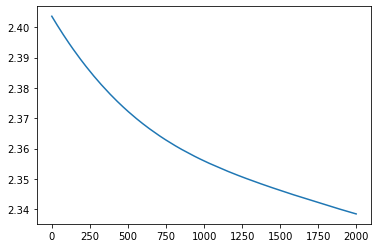

In [159]:
with torch.no_grad():
    plt.plot(history_loss)

In [160]:
encoder_opt = CategoricalEncoder(decoder.mu.transpose(0,1),decoder.sigma.transpose(0,1),decoder.q)

<ipython-input-77-1a2876877df6>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.c = torch.nn.Parameter(-mu0**2/(2*sigma0**2) -torch.log(sigma0) - torch.log(F.softmax(q0)))


In [165]:
encoder_opt(x_sorted)
p_j_x = encoder_opt(x_sorted)

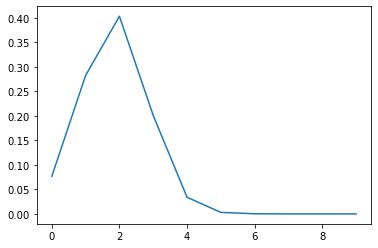

In [162]:
with torch.no_grad():
    plt.plot(p_j_x[100,:])

In [163]:
q_samples = [torch.distributions.categorical.Categorical(p_j_x[_,:]).sample((10,)) for _ in np.arange(500)]

In [153]:
x_sampled = [torch.distributions.normal.Normal(decoder.mu[q_samples[_]],decoder.sigma[q_samples[_]]).sample() for _ in np.arange(500)]

In [154]:
x_sampled = torch.cat(x_sampled)

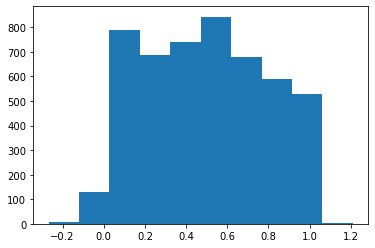

In [208]:
q_sampled = torch.multinomial(p_j_x,100,replacement= True)
mu,sigma = decoder.mu[q_sampled],decoder.sigma[q_sampled]
x_sampled = torch.distributions.normal.Normal(mu,sigma).sample()

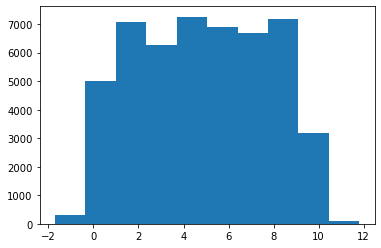

In [209]:
with torch.no_grad():
    plt.hist(torch.flatten(x_sampled).numpy())

In [203]:
((x_sampled - x_sorted[:,None])**2).mean()

tensor(1.5970)

In [48]:
class dummy(torch.nn.Module):
    def __init__(self,a0):
        super().__init__()
        self.a,self.b = custom_init(a0)
    def forward(self,x):
        return (self.a@x).sum()

In [49]:
def custom_init(a0):
    return torch.nn.Parameter(2*a0),torch.nn.Parameter(a0**2)

In [50]:
a0 = torch.ones(10)
x = torch.randn(10,2)

In [51]:
myd = dummy(a0)


In [52]:
params = myd.parameters()#list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.SGD(params,0.01)

In [53]:
loss = myd(x)
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [54]:
myd(x).sum()

tensor(1.0240, grad_fn=<SumBackward0>)

In [55]:
a0

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])